In [1]:
import itertools
import pandas as pd
pd.options.display.max_columns = 300
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
%matplotlib inline

In [ ]:
df_raw = pd.read_csv('survey_results_public.csv', index_col='Respondent')
df_raw = df_raw[df_raw['Salary'].notnull()]

In [86]:
# todo: support splitting by semicolon
def do_regression(df, discrete_cols=[], multi_select_cols=[]):
    df = df[discrete_cols + ['Salary']]
    df = pd.get_dummies(df)
    for multi_select_col in multi_select_cols:
        to_concat = df_raw[multi_select_col].str.get_dummies(sep='; ')
        df = pd.concat([df, to_concat], axis=1)
    
    train = df.sample(frac=0.9)
    test = df.drop(train.index)
    
    reg = linear_model.LinearRegression()
    reg.fit(train.drop(columns='Salary'), train['Salary'])
    coeffs = dict(zip(
        filter(lambda c: c!='Salary', test.columns),
        reg.coef_
    ))
    
    predictions = reg.predict(test.drop(columns='Salary'))
    errors = predictions - test['Salary'].values
    plt.hist(errors, bins=20)
    plt.show()
    
    print('R^2 = {}'.format(reg.score(test.drop(columns='Salary'),
                                      test['Salary'])))
    return coeffs

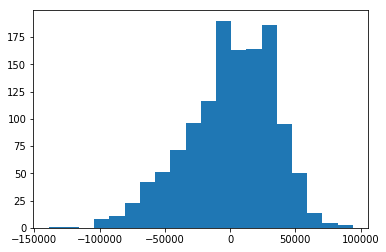

R^2 = 0.28308520009058946


In [87]:
result = do_regression(
    df_raw,
    discrete_cols=['CompanySize', 'YearsCodedJob'])

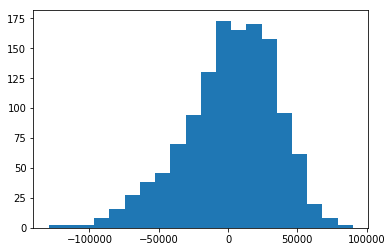

R^2 = 0.24450499569585193


In [88]:
result = do_regression(
    df_raw,
    discrete_cols=['CompanySize', 'YearsCodedJob'],
    multi_select_cols=['DeveloperType'])

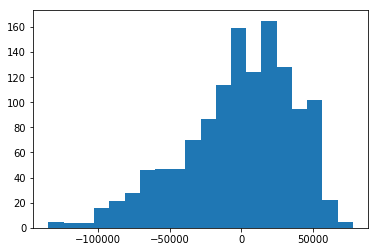

R^2 = 0.029295273099007257


{'Data scientist': 1312.3387286363077,
 'Database administrator': -3600.7169524089777,
 'Desktop applications developer': 1364.0780578868576,
 'DevOps specialist': 12324.645947511537,
 'Developer with a statistics or mathematics background': 5459.235189621178,
 'Embedded applications/devices developer': 2270.829710597797,
 'Graphic designer': -6758.716124938141,
 'Graphics programming': -874.171198849458,
 'Machine learning specialist': 6444.157152715483,
 'Mobile developer': -5900.731927743842,
 'Other': 16085.042535669803,
 'Quality assurance engineer': -1147.532257596014,
 'Systems administrator': -1199.2431899905387,
 'Web developer': -1568.3058919791783}

In [93]:
result = do_regression(
    df_raw,
    multi_select_cols=['DeveloperType'])
result

In [98]:
df2 = df_raw['DeveloperType'].str.get_dummies(sep='; ')
df2 = df2 / df2.sum(axis=1)

In [ ]:
df2